In [2]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import rcParams
import time
from copy import copy as dup
from scipy.integrate import solve_ivp

# My modules
import diffusionstuff10 as ds

In [3]:
# Graphics parameters
%matplotlib notebook
ticklabelsize = 11
fontsize = 15
linewidth = 2

### The cell below specifies parameters for the 0-d and 1-d runs

<IPython.core.display.Javascript object>


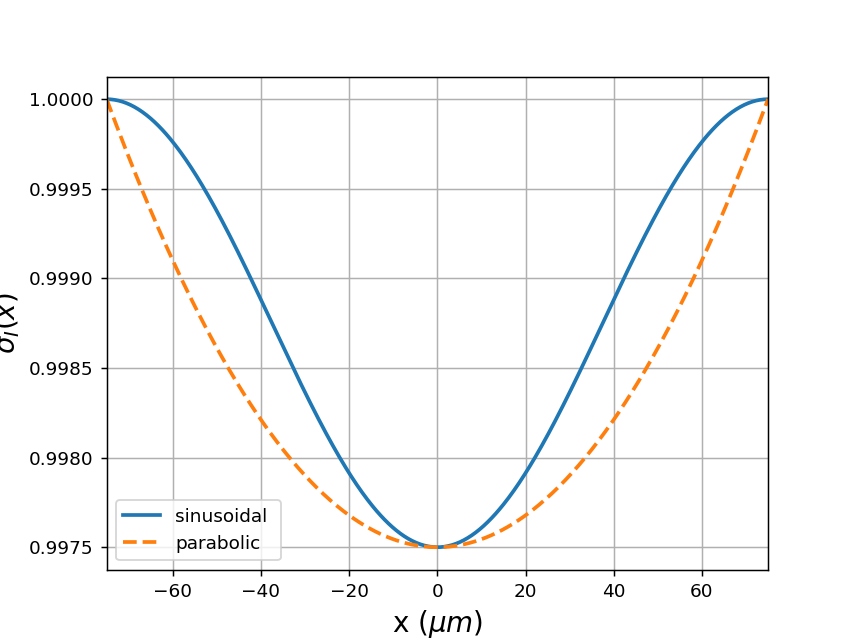

D = 0.001 um^2/us 1.0 x 10^-9 m^2/sec
nu_kin_mlyperus = 0.11333333333333333 monolayers/us
nmid = 250
N* = 0.1432394487827058
N*x2pi = 0.9
Nbar, Nbar-N*, N*/Nbar = 1.0 0.8567605512172942 0.1432394487827058
deltax = 0.3
sigma_0 = 0.19
sigmaIcorner = 0.2
center reduction = 0.25 %
c_r = 0.0025 dimensionless
max growth rate = 6.800000000000001 um/sec
min growth rate = 0.3400000000000003 um/sec
nu_kin = 34 um/sec
dx = 0.3
L = 75.0 micrometers
tau_eq = 1 microseconds
deltat_max (Diffusion time) = 90.0
corner supersaturation (%) = 5.263157894736847


In [4]:
#Setting up the system
nx = 501 # Number of points in simulation box
xmax = 150
x = np.linspace(0, xmax, nx)
boxpoints = len(x)
deltax = x[1]-x[0]
Nbar = 1.0 # new Nbar from VMD, 260K
Nstar = .9/(2*np.pi)
nmid = int(nx/2)
xmid = max(x)/2
xmax = x[nx-1]
L = xmax/2
tau_eq = 1

# Just conversions
nmpermonolayer = 0.3
umpersec_over_mlyperus = (nmpermonolayer/1e3*1e6)

# Diffusion coefficient
D = 1e-3 # micrometers^2/microsecond
# D = 5e-4 # micrometers^2/microsecond
# D = 2e-4 # micrometers^2/microsecond
# D = 1.6e-4 # micrometers^2/microsecond
# D = 2e-5 # micrometers^2/microsecond
# D = 8e-6 # micrometers^2/microsecond
# D = 2e-7 # micrometers^2/microsecond

# The so-called diffusion time
dtmax = deltax**2/D

# Deposition rate
nu_kin = 34 # microns/second - about right for 240 K
# nu_kin = 49 # microns/second - between 240 and 260 K
# nu_kin = 75 # microns/second - between 240 and 260 K
# nu_kin = 80 # microns/second - between 240 and 260 K
# nu_kin = 90 # microns/second - between 240 and 260 K
# nu_kin = 100 # microns/second - between 240 and 260 K
# nu_kin = 150 # microns/second - between 240 and 260 K
# nu_kin = 250 # microns/second - about right for 260 K
nu_kin_mlyperus = nu_kin/umpersec_over_mlyperus # monolayers per microsecond

# Supersaturation
sigma0 = 0.19
# sigmaIcorner = 0.191 # Must be bigger than sigma0 to get growth
# sigmaIcorner = 0.192 # Must be bigger than sigma0 to get growth
# sigmaIcorner = 0.193 # Must be bigger than sigma0 to get growth
# sigmaIcorner = 0.194 # Must be bigger than sigma0 to get growth
# sigmaIcorner = 0.195 # Must be bigger than sigma0 to get growth
sigmaIcorner = 0.20 # Must be bigger than sigma0 to get growth
# sigmaIcorner = 0.21 # Must be bigger than sigma0 to get growth
center_reduction = 0.25 # In percent
c_r = center_reduction/100

# Diffusion coefficient scaled for this time step and space step
Doverdeltax2 = D/deltax**2

# Overlying supersaturation
sigmaI_sinusoid = ds.getsigmaI(x,xmax,center_reduction,sigmaIcorner,method='sinusoid')
sigmaI_parabolic = ds.getsigmaI(x,xmax,center_reduction,sigmaIcorner,method='parabolic')
# sigmaIstyle = 'sinusoid'
sigmaIstyle = 'parabolic'
if sigmaIstyle=='sinusoid':
    sigmaI = sigmaI_sinusoid
elif sigmaIstyle=='parabolic':
    sigmaI = sigmaI_parabolic
else:
    print('bad choice')
plt.figure()
plt.plot(x-xmid,sigmaI_sinusoid/sigmaIcorner, \
         x-xmid, sigmaI_parabolic/sigmaIcorner, '--',lw=linewidth)
plt.xlim([-xmid,xmid])
plt.legend(['sinusoidal ', 'parabolic'])
plt.xlabel(r'x ($\mu m$)',fontsize=fontsize)
plt.ylabel(r'$\sigma_I(x) $',fontsize=fontsize)
plt.grid('on')

# 0D run parameters
uselayers = True
if uselayers:
    layermax_0D = 20
else:
    countermax_0D = 100

# 1D run parameters
if uselayers:
    layermax_1D = 2000
else:
    countermax_1D = 20000

# Integrator
# odemethod ='Radau' # much too slow (implicit)
# odemethod ='BDF' # still slow (implicit), faster than Radau, results closest to DOP853 and LSODA
# odemethod ='DOP853' # slowest of explicit methods
odemethod ='LSODA' # results are a lot like DOP853, but faster
# odemethod ='RK45' # faster, but results look different from LSODA
# odemethod ='RK23' # fastest, produces V-shaped profiles

# Reporting
print("D =", D, 'um^2/us',D * 1e-12*1e6*1e9, 'x 10^-9 m^2/sec')
print('nu_kin_mlyperus =', nu_kin_mlyperus, 'monolayers/us')
print('nmid =', nmid)
print('N* =', Nstar)
print('N*x2pi =', Nstar*2*np.pi)
print('Nbar, Nbar-N*, N*/Nbar =', Nbar, Nbar-Nstar, Nstar/Nbar)
print('deltax =', deltax)
print('sigma_0 =', sigma0)
print('sigmaIcorner =', sigmaIcorner)
print('center reduction =', center_reduction, '%')
print('c_r =', c_r, 'dimensionless')
print('max growth rate =', nu_kin_mlyperus*sigmaIcorner*umpersec_over_mlyperus, 'um/sec')
print('min growth rate =', nu_kin_mlyperus*(sigmaIcorner-sigma0)*umpersec_over_mlyperus, 'um/sec')
print('nu_kin =', nu_kin, 'um/sec')
print('dx =', deltax)
print('L =', L, 'micrometers')
print('tau_eq =', tau_eq, 'microseconds')
print('deltat_max (Diffusion time) =', dtmax)
print('corner supersaturation (%) =', (sigmaIcorner-sigma0)/sigma0*100)

### This is the 0-d run

In [5]:
# Time steps
t_init = 0.0
dtmaxtimefactor = 10
deltat_0D = dtmax/dtmaxtimefactor
tinterval = [t_init, t_init+deltat_0D]
print('deltat_0D =', deltat_0D)

# Bundle parameters for ODE solver
params = np.array([Nbar, Nstar, sigmaIcorner, sigma0, nu_kin_mlyperus, tau_eq])
print(params)

# Initialize as a pre-equilibrated layer of liquid over ice
Ntot_init_0D = 0
NQLL_init_0D = ds.getNQLL(Ntot_init_0D,Nstar,Nbar)

# Initialize the keeper arrays
tkeep_0D = []
ykeep_0D = []
tlast = t_init

# Call the ODE solver
ylast = np.array([NQLL_init_0D,Ntot_init_0D])
counter = 0
ttot = 0.0
while True:
    
    # Integrate up to next time step
    sol = solve_ivp(ds.f0d_solve_ivp, tinterval, ylast, dense_output=True, args=(params,),rtol=1e-12,method=odemethod)

    ylast = sol.y[:,-1]
    tlast += deltat_0D
    
    # Stuff into keeper arrays
    ykeep_0D.append(ylast)
    tkeep_0D.append(tlast)
    
    # Update counters and see whether to break
    NQLLlast, Ntotlast = ylast
    counter += 1
    if uselayers:
        if Ntotlast > layermax_0D-1:
            break
    else:
        if counter > countermax_0D-1:
            break
print('At the end, counter =', counter)

deltat_0D = 9.0
[1.         0.14323945 0.2        0.19       0.11333333 1.        ]
At the end, counter = 514


In [6]:
# Convert results to a numpy array
ykeep_0D = np.array(ykeep_0D, np.float64)
NQLLkeep_0D = ykeep_0D[:,0]
Ntotkeep_0D = ykeep_0D[:,1]
tkeep_0Darr = np.array(tkeep_0D, np.float64)

0-D Modeled growth rate, um/s 1.2374783477358784
0-D Modeled growth rate, ml/us 0.004124927825786261
0-D Modeled alpha 0.18198210996115857


<IPython.core.display.Javascript object>


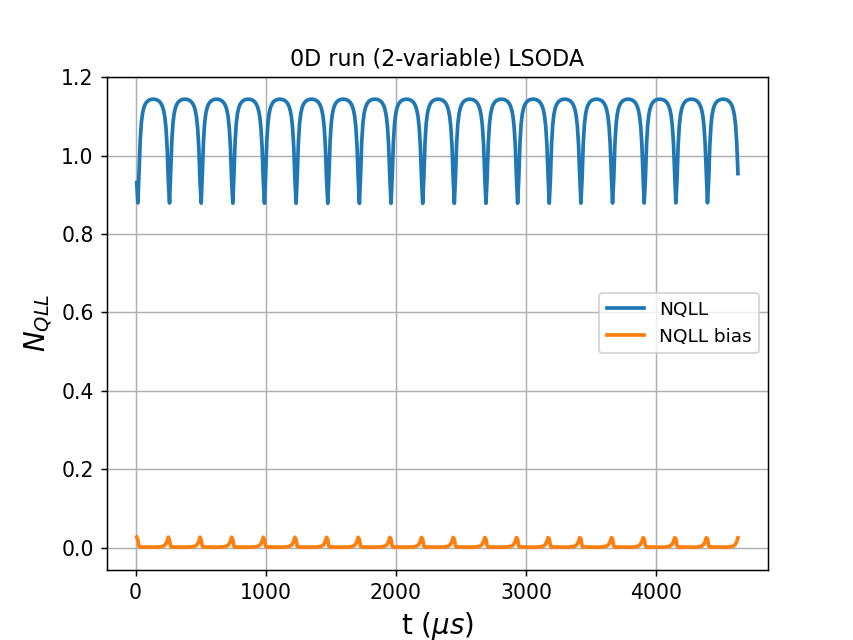

In [7]:
# Growth statistics
delta_Ntot_0D = Ntotkeep_0D[-1]-Ntot_init_0D
growthrate_0D_mlyperus = delta_Ntot_0D/tlast # monolayer/us
growthrate_0D = growthrate_0D_mlyperus*umpersec_over_mlyperus # um/sec
print( "0-D Modeled growth rate, um/s", growthrate_0D)
print( "0-D Modeled growth rate, ml/us", growthrate_0D_mlyperus)
alpha_0D = growthrate_0D/nu_kin/sigmaIcorner
print( "0-D Modeled alpha", alpha_0D)
title = '0D run (2-variable) '+odemethod

# Plot results
plt.figure()
rcParams['xtick.labelsize'] = ticklabelsize 
rcParams['ytick.labelsize'] = ticklabelsize
plt.plot(tkeep_0D,NQLLkeep_0D,lw=linewidth,label='NQLL')
plt.plot(tkeep_0D,NQLLkeep_0D-ds.getNQLL(Ntotkeep_0D,Nstar,Nbar),lw=linewidth,label='NQLL bias')
plt.xlabel(r't ($\mu s$)',fontsize=fontsize)
plt.ylabel(r'$N_{QLL} $',fontsize=fontsize)
plt.grid('on')
plt.title(title)
plt.legend()

### Prepping the 1-d run

In [13]:
# Time steps
t_init = 0.0
deltat_1D = deltat_0D*100
tinterval = [t_init, t_init+deltat_1D]
print('deltat_1D =', deltat_1D)

# Bundle parameters for ODE solver
scalar_params = np.array([Nbar, Nstar, sigma0, nu_kin_mlyperus, Doverdeltax2, tau_eq])

# Initialize as a pre-equilibrated layer of liquid over ice
Ntot_init_1D = np.ones(nx)
NQLL_init_1D = ds.getNQLL(Ntot_init_1D,Nstar,Nbar)

# Initialize the keeper arrays
tkeep_1D = []
ykeep_1D = []
tlast = t_init

# Set up initial condidions
ylast = np.array([NQLL_init_1D, Ntot_init_1D])
ylast = np.reshape(ylast,2*nx)

deltat_1D = 900.0


In [14]:
test = ds.f1d_solve_ivp(t_init, ylast, scalar_params, sigmaI)
print(test)

[0.01086758 0.01086717 0.01086676 ... 0.01086676 0.01086717 0.01086758]


### This is the 1-d run

In [15]:
counter = 0
layer = 0
ttot = 0.0
while True:
    # Integrate up to next time step
    sol = solve_ivp(ds.f1d_solve_ivp, tinterval, ylast, args=(scalar_params,sigmaI),rtol=1e-12,method=odemethod)
    ylast = sol.y[:,-1]
    tlast += deltat_1D
        
    # Stuff into keeper arrays
    ykeep_1D.append(ylast)
    tkeep_1D.append(tlast)

    # Make some local copies
    ttot += deltat_1D

    # Update counters and see whether to break
    NQLLlast, Ntotlast = np.reshape(ylast,(2,nx))
    minpoint = min(Ntotlast)
    maxpoint = max(Ntotlast)
    print(counter, int(Ntotlast[0]), maxpoint-minpoint)
    counter += 1
    if uselayers:
        if Ntotlast[0] > layermax_1D-1:
            break
    else:
        if counter > countermax_1D-1:
            break

0 4 0.023720827671876776
1 8 0.09079964176759425
2 12 0.6162876915906246
3 15 0.10080160047186482
4 19 0.7153320056661059
5 23 0.8625592628340755
6 26 0.24459516108713686
7 30 0.9426236576274185
8 34 0.9651558121674384
9 38 0.984518322444373
10 41 1.021961210300077
11 45 1.0775626742777504
12 49 1.6285574961914122
13 52 1.0960450178226822
14 56 1.6590260180603167
15 60 1.8515993895748437
16 63 1.22166370084787
17 67 1.9308850551412746
18 71 1.950489191360191
19 74 1.8573038642836934
20 78 2.008727356523096
21 82 2.0530703487574016
22 86 2.4205905761353392
23 89 2.0721056561648936
24 93 2.573650588346595
25 97 2.7492719825761895
26 100 2.1660844595793094
27 104 2.903084765845719
28 108 2.882294950871227
29 111 2.6623267221074656
30 115 2.978577854176848
31 119 2.9899600610641954
32 122 3.054269814569878
33 126 3.031512597347273
34 130 3.4393964526963003
35 133 3.1754245918446315
36 137 3.103945573567728
37 141 3.8431248499533694
38 145 3.288048578471802
39 148 3.4965812345266727
40 152 

321 1167 6.96858304458101
322 1171 6.950819677540494
323 1174 6.8987938947707335
324 1178 6.972526617480526
325 1182 6.778488374146491
326 1185 6.967855412016661
327 1189 6.952868802537296
328 1192 6.889075677970823
329 1196 6.972795830250789
330 1200 6.809516362417071
331 1203 6.967044802474675
332 1207 6.954761102188513
333 1210 6.877807196216281
334 1214 6.973021744003745
335 1218 6.835701490838801
336 1221 6.966144705494571
337 1225 6.956507197137853
338 1228 6.864706465009931
339 1232 6.973206042230686
340 1236 6.857047091024924
341 1239 6.965147695627138
342 1243 6.958117928933689
343 1246 6.849454500060574
344 1250 6.973350057117159
345 1254 6.874029338304808
346 1257 6.964044998579993
347 1261 6.959603502775963
348 1264 6.8317108058388385
349 1268 6.973454690297331
350 1272 6.88728227777824
351 1275 6.962826375321583
352 1279 6.960973340227383
353 1282 6.811153655155977
354 1286 6.973520539325136
355 1290 6.897443567020673
356 1293 6.961480121092109
357 1297 6.9622365883165
358

In [16]:
# Get the amount of ice for the last step
Nicelast = Ntotlast - NQLLlast

# Reshape results over time
tkeep_1Darr = np.array(tkeep_1D, np.float64)
ykeep_1Darr = np.array(ykeep_1D, np.float64)
ykeep_1Darr_reshaped = np.reshape(ykeep_1Darr,(counter,2,nx))
print(np.shape(ykeep_1Darr_reshaped))
Ntotkeep_1D = ykeep_1Darr_reshaped[:,1,:]
NQLLkeep_1D = ykeep_1Darr_reshaped[:,0,:]
Nicekeep_1D = Ntotkeep_1D - NQLLkeep_1D

(553, 2, 501)


1-D growth rate, ml/us 0.04433311600054454
1-D growth rate, um/s 13.299934800163363
1-D alpha 1.9558727647299063
slowdown 974.76 %
Libbrecht's predicted growth rate 1.2762893676518576 um/s
Libbrecht's predicted alpha 0.18768961288997904


<IPython.core.display.Javascript object>


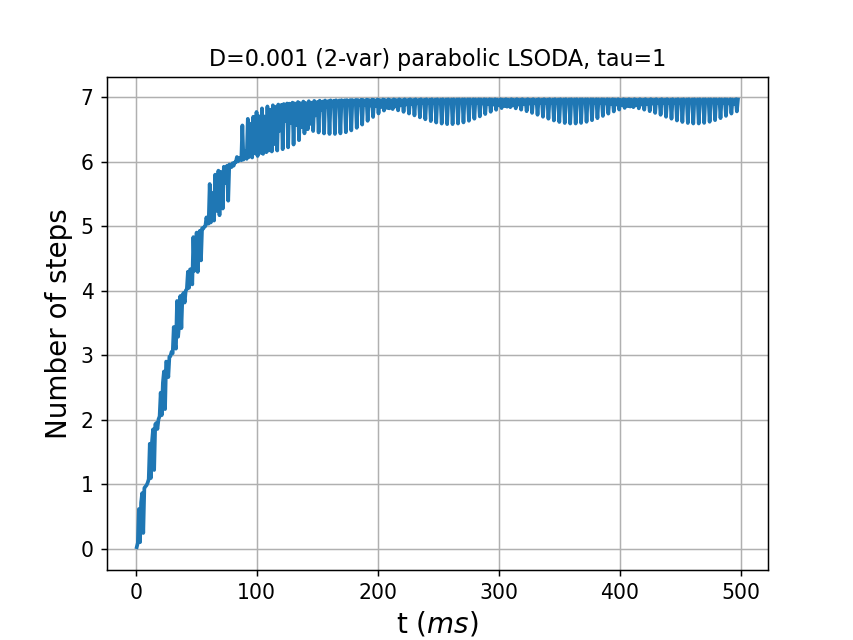

<IPython.core.display.Javascript object>


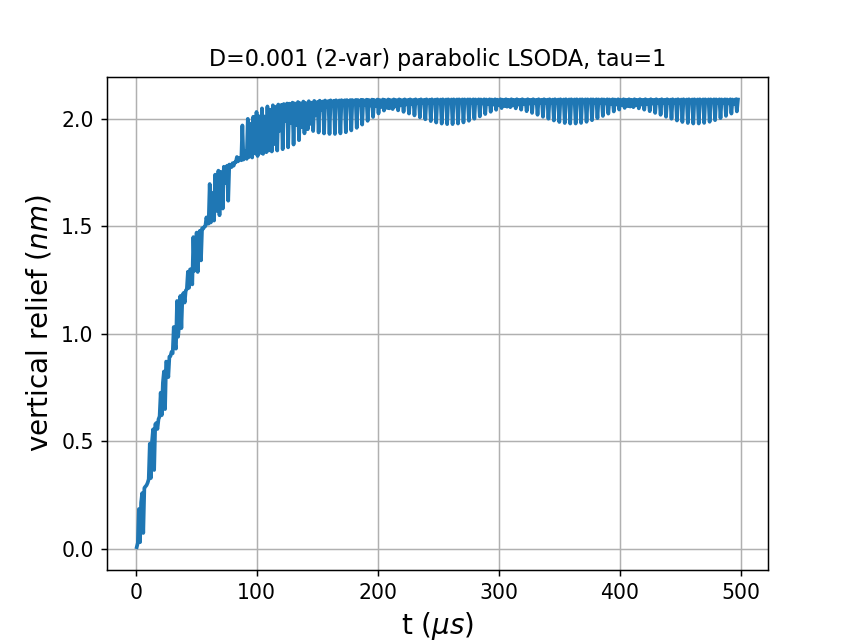

<IPython.core.display.Javascript object>


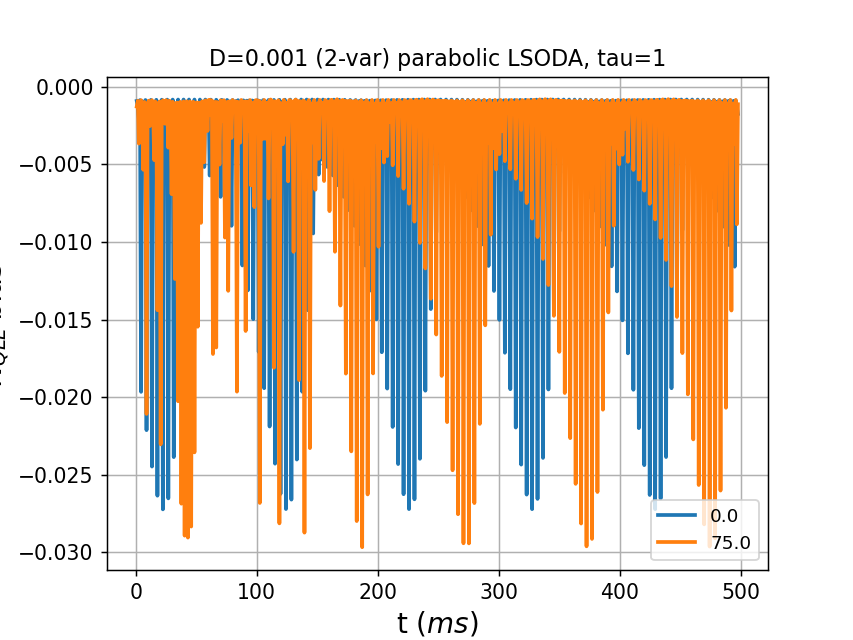

<IPython.core.display.Javascript object>


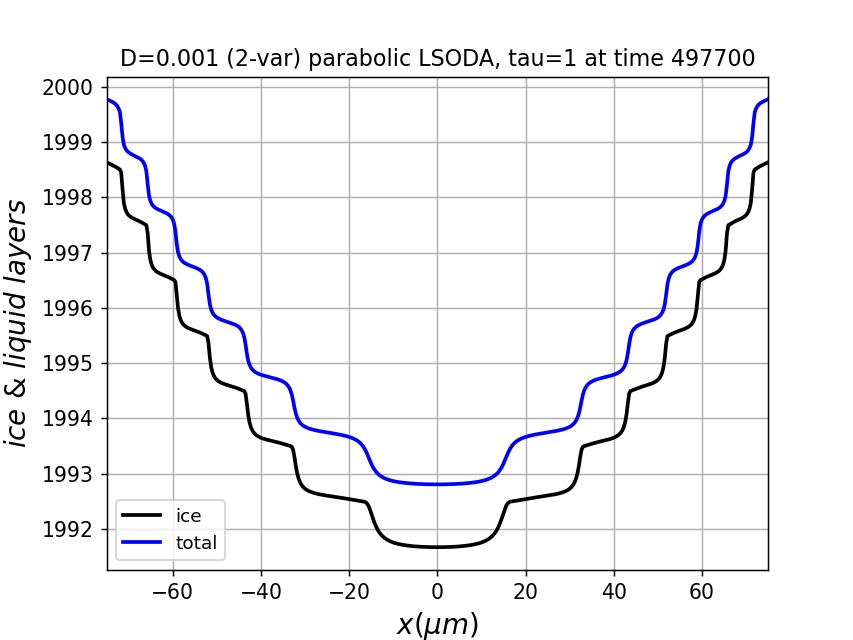

<IPython.core.display.Javascript object>


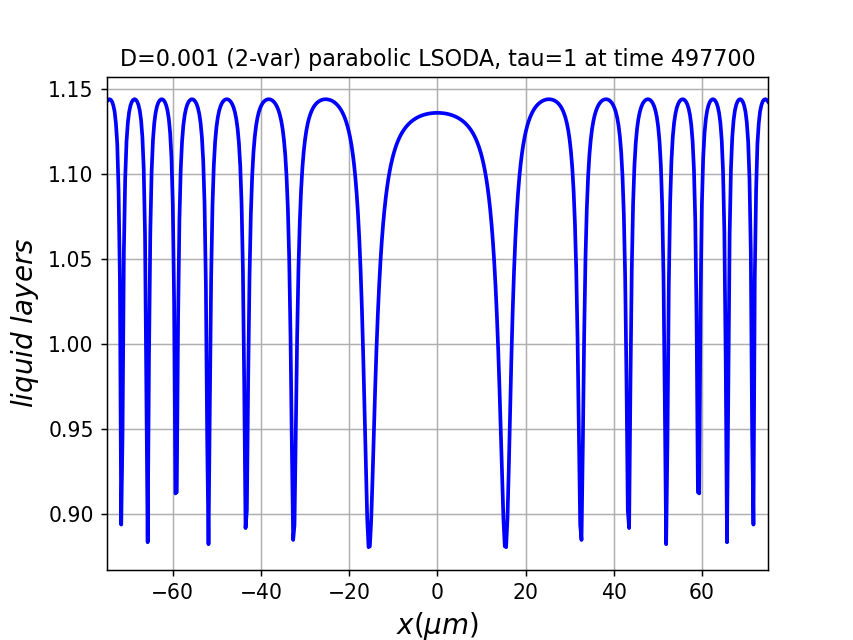

In [69]:
# Growth statistics
delta_Ntot_1D = Ntotkeep_1D[-1,0]-Ntotkeep_1D[0,0]
growthrate_1D_mlyperus = delta_Ntot_1D/tlast; print( "1-D growth rate, ml/us", growthrate_1D_mlyperus)
growthrate_1D = growthrate_1D_mlyperus*umpersec_over_mlyperus; print( "1-D growth rate, um/s", growthrate_1D)
alpha_1D = growthrate_1D/nu_kin/sigmaIcorner; print( "1-D alpha", alpha_1D)
slowdown = (alpha_1D-alpha_0D)/alpha_0D*100; print("slowdown", int(slowdown*100)/100,'%')
Nicekeep_1D = Ntotkeep_1D-NQLLkeep_1D
title = 'D='+str(D)+' (2-var) '+sigmaIstyle+' '+odemethod+', tau='+str(tau_eq)

# Comparisons with Libbrecht
sigma0_L = 0.08
A_L = .28
alpha_L = A_L*np.exp(-sigma0_L/sigmaIcorner)
print("Libbrecht's predicted growth rate", nu_kin*alpha_L*sigmaIcorner, "um/s")
print("Libbrecht's predicted alpha", alpha_L)

# # Plot number of steps over time (with index on the x-axis)
# plt.figure()
# rcParams['xtick.labelsize'] = ticklabelsize 
# rcParams['ytick.labelsize'] = ticklabelsize
# f = np.max(Ntotkeep_1D,axis=1) - np.min(Ntotkeep_1D,axis=1)
# plt.plot(f,lw=linewidth)
# plt.xlabel('index',fontsize=fontsize)
# plt.ylabel('Number of steps',fontsize=fontsize)
# plt.title(title)
# plt.grid('on')
# # plt.xlim([550,620])

# Plot number of steps over time
plt.figure()
rcParams['xtick.labelsize'] = ticklabelsize 
rcParams['ytick.labelsize'] = ticklabelsize
f = np.max(Ntotkeep_1D,axis=1) - np.min(Ntotkeep_1D,axis=1)
plt.plot(tkeep_1Darr/1e3,f,lw=linewidth)
plt.xlabel(r't ($m s$)',fontsize=fontsize)
plt.ylabel('Number of steps',fontsize=fontsize)
plt.title(title)
plt.grid('on')

# Plot number of steps as vertical distance over time
plt.figure()
rcParams['xtick.labelsize'] = ticklabelsize 
rcParams['ytick.labelsize'] = ticklabelsize
f = np.max(Ntotkeep_1D,axis=1) - np.min(Ntotkeep_1D,axis=1)
f *= nmpermonolayer
plt.plot(tkeep_1Darr/1e3,f,lw=linewidth)
plt.xlabel(r't ($\mu s$)',fontsize=fontsize)
plt.ylabel(r'vertical relief ($nm$)',fontsize=fontsize)
plt.title(title)
plt.grid('on')

# Plot NQLL over time
iposition1 = nmid; NQLL_in_equilibrium_with_Ntot_1 = ds.getNQLL(Ntotkeep_1D[:,iposition1],Nstar,Nbar)
iposition2 = -1;   NQLL_in_equilibrium_with_Ntot_2 = ds.getNQLL(Ntotkeep_1D[:,iposition2],Nstar,Nbar)
plt.figure()
rcParams['xtick.labelsize'] = ticklabelsize 
rcParams['ytick.labelsize'] = ticklabelsize
plt.plot(tkeep_1Darr/1e3,NQLL_in_equilibrium_with_Ntot_1-NQLLkeep_1D[:,iposition1],lw=linewidth,label=str(x[iposition1]-xmid))
plt.plot(tkeep_1Darr/1e3,NQLL_in_equilibrium_with_Ntot_2-NQLLkeep_1D[:,iposition2],lw=linewidth,label=str(x[iposition2]-xmid))
# plt.xlabel(r't ($\mu s$)',fontsize=fontsize)
plt.xlabel(r't ($m s$)',fontsize=fontsize)
plt.ylabel(r'$N_{QLL} \ bias$',fontsize=fontsize)
plt.title(title)
plt.legend()
plt.grid('on')

# Plot ice and total
itime = -1
plt.figure()
plt.plot(x-xmid, Nicekeep_1D[itime,:], 'k', label='ice', lw=linewidth)
plt.plot(x-xmid, Ntotkeep_1D[itime,:], 'b', label='total', lw=linewidth)
plt.xlabel(r'$x (\mu m$)',fontsize=fontsize)
plt.ylabel(r'$ice \ & \ liquid \ layers$',fontsize=fontsize)
plt.xlim([-xmid, xmid])
rcParams['xtick.labelsize'] = ticklabelsize 
rcParams['ytick.labelsize'] = ticklabelsize
plt.legend()
plt.title(title+' at time '+str(int(tkeep_1D[itime])))
plt.grid('on')

# Plot liquid
itime = -1
plt.figure()
plt.plot(x-xmid, NQLLkeep_1D[itime,:], 'b', label='liquid', lw=linewidth)
plt.xlabel(r'$x (\mu m$)',fontsize=fontsize)
plt.ylabel(r'$liquid \ layers$',fontsize=fontsize)
plt.xlim([-xmid, xmid])
rcParams['xtick.labelsize'] = ticklabelsize 
rcParams['ytick.labelsize'] = ticklabelsize
plt.title(title+' at time '+str(int(tkeep_1D[itime])))
plt.grid('on')

### Perturbations to steady state
I wrote this code, and it works, I'm just not sure what we can learn from it.

<IPython.core.display.Javascript object>


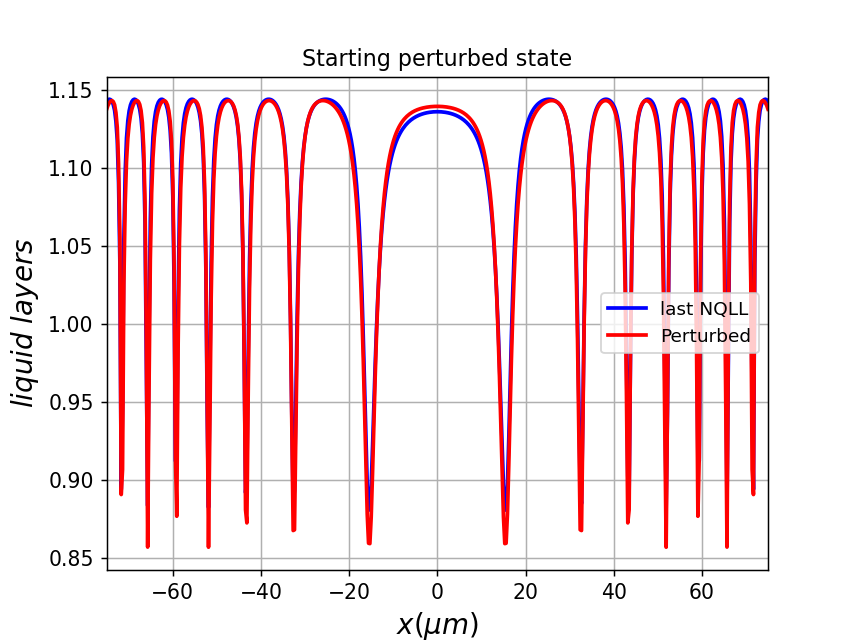

<IPython.core.display.Javascript object>


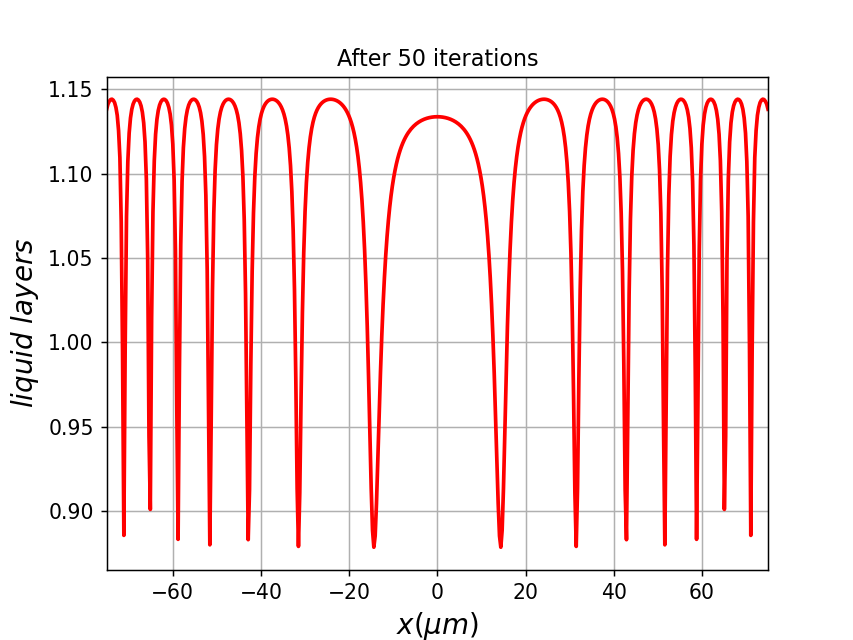

In [67]:
# mode = 1
# amp = -Nbar/50
# Ntot_perturbation = np.cos((x-xmid)/xmid*np.pi*mode)*amp
# Ntot_init_perturbed = Ntotlast + Ntot_perturbation
# NQLL_init_perturbed = ds.getNQLL(Ntot_init_perturbed,Nstar,Nbar)
# Nice_init_perturbed = Ntot_init_perturbed - NQLL_init_perturbed

# # Plot NQLL (last and perturbed)
# plt.figure()
# plt.plot(x-xmid, NQLLlast, 'b', label='last NQLL', lw=linewidth)
# plt.plot(x-xmid, NQLL_init_perturbed, 'r', label='Perturbed', lw=linewidth)
# plt.xlabel(r'$x (\mu m$)',fontsize=fontsize)
# plt.ylabel(r'$liquid \ layers$',fontsize=fontsize)
# plt.xlim([-xmid, xmid])
# rcParams['xtick.labelsize'] = ticklabelsize 
# rcParams['ytick.labelsize'] = ticklabelsize
# plt.legend()
# plt.grid('on')
# plt.title('Starting perturbed state')

# # # Plot ice and total (last and perturbed)
# # plt.figure()
# # plt.plot(x-xmid, Nicelast, 'k', label='ice', lw=linewidth)
# # plt.plot(x-xmid, Ntotlast, 'b', label='total', lw=linewidth)
# # plt.plot(x-xmid, Nice_init_perturbed, 'k--', lw=linewidth)
# # plt.plot(x-xmid, Ntot_init_perturbed, 'b--', lw=linewidth)
# # plt.xlabel(r'$x (\mu m$)',fontsize=fontsize)
# # plt.ylabel(r'$ice \ & \ liquid \ layers$',fontsize=fontsize)
# # plt.xlim([-xmid, xmid])
# # rcParams['xtick.labelsize'] = ticklabelsize 
# # rcParams['ytick.labelsize'] = ticklabelsize
# # plt.legend()
# # plt.grid('on')
# # plt.title('Starting perturbed state')

# Iwantperturbations = True
# if Iwantperturbations:

#     # Set up initial condidions
#     ylast = np.array([NQLL_init_perturbed, Ntot_init_perturbed])
#     ylast = np.reshape(ylast,2*nx)
    
#     # Accumulators
#     tkeep_perturbed = []
#     ykeep_perturbed = []
#     tlast = t_init

#     # Decide how long to integrate
#     countermax_perturbed = 50
#     counter = 0
#     layer = 0
#     ttot = 0.0
        
#     while True:
#         # Integrate up to next time step
#         sol = solve_ivp(ds.f1d_solve_ivp, tinterval, ylast, args=(scalar_params,sigmaI),rtol=1e-12,method=odemethod)
#         ylast = sol.y[:,-1]
#         tlast += deltat_1D

#         # Stuff into keeper arrays
#         ykeep_perturbed.append(ylast)
#         tkeep_perturbed.append(tlast)

#         # Make some local copies
#         ttot += deltat_1D

#         # Update counters and see whether to break
#         NQLLlast_perturbed, Ntotlast_perturbed = np.reshape(ylast,(2,nx))
#         minpoint = min(Ntotlast_perturbed)
#         maxpoint = max(Ntotlast_perturbed)
#         #print(counter, int(Ntotlast_perturbed[0]), maxpoint-minpoint)
#         counter += 1
#         if counter > countermax_perturbed-1:
#                 break
#     # Plot NQLL (last and perturbed)
#     plt.figure()
#     plt.plot(x-xmid, NQLLlast_perturbed, 'r', label='Perturbed', lw=linewidth)
#     plt.xlabel(r'$x (\mu m$)',fontsize=fontsize)
#     plt.ylabel(r'$liquid \ layers$',fontsize=fontsize)
#     plt.xlim([-xmid, xmid])
#     rcParams['xtick.labelsize'] = ticklabelsize 
#     rcParams['ytick.labelsize'] = ticklabelsize
#     plt.grid('on')
#     plt.title('After '+str(counter)+' iterations')

# #     # Plot ice and total (last and perturbed)
# #     Nicelast_perturbed = Ntotlast_perturbed - NQLLlast_perturbed
# #     plt.figure()
# #     plt.plot(x-xmid, Nicelast_perturbed, 'k--', lw=linewidth)
# #     plt.plot(x-xmid, Ntotlast_perturbed, 'b--', lw=linewidth)
# #     plt.xlabel(r'$x (\mu m$)',fontsize=fontsize)
# #     plt.ylabel(r'$ice \ & \ liquid \ layers$',fontsize=fontsize)
# #     plt.xlim([-xmid, xmid])
# #     rcParams['xtick.labelsize'] = ticklabelsize 
# #     rcParams['ytick.labelsize'] = ticklabelsize
# #     plt.grid('on')
# #     plt.title('After '+str(counter)+' iterations')


### The cell below is just backup for parameters, and allows some exploration (but not part of the simulation)

In [24]:
# # Exploring the D^.5 dependence of lambda
# plt.figure()
# Dlist = np.array([1e-3, 5e-4, 2e-4])/2e-4
# nsteadystatelist = np.array([7,10,16])
# lambdalist = 75/nsteadystatelist
# plt.plot(Dlist**.5,lambdalist,'o')
# plt.grid(True)
# plt.xlabel(r'$D^{1/2}$',fontsize=fontsize)
# plt.ylabel(r'$\lambda$',fontsize=fontsize)




# # The time required for an initial gaussian to diffuse
# layer_growth_rate = growthrate_0D/umpersec_over_mlyperus; print('Layer growth rate =', layer_growth_rate)
# t = 1/layer_growth_rate; print('Time to add a layer =', t)
# t = 2.5**2/D; print('Time to diffuse across a terrace =', t)
# t = deltax**2/D; print('Time for equilibration across dx =', t)
# t = 0.001; print('Time for ice-QLL equilibration =', t)

# # How a change in the crystal size could be used to calculate a new diffusion coefficient with the same D/dx^2
# D_old = 2e-6
# D_new = D_old/50**2*100**2; print(D_new)

# # Computing the kinetic deposition velocity ... roughly, 260 
# M = 18 # g/mol
# T = 260 # K
# NA = 6.02e23
# m = M/NA; print(m,'mass of a molecule of water, grams/mol')
# m /= 1e3; print(m,'mass of a molecule of water, kg/mol')
# R = 8.314 # J/K-mol
# k = R/NA; print(k,"Boltzmann's constant, J/K")

# Pvap = 200 # Pascals (see https://byjus.com/clausius-clapeyron-equation-calculator/)
# V_gas = R*T/Pvap # Must be in m^3
# V_gas *= (10/1)**3; print(V_gas, 'Liters') 
# V_gas *= (10/1)**3; print(V_gas, 'cm^3') # see https://www.omnicalculator.com/physics/ideal-gas-law
# c_sat = 1/V_gas # mol/cm^3
# c_sat*=M; print(c_sat,'density of vapor, g/cm^3')

# c_solid = 0.92; print(c_solid, 'density of ice, g/cm^3')
# V_solid = 1/c_solid # cm^3/g

# V_ratio = V_gas/V_solid; print(V_ratio,'ratio of volumes')
# c_ratio = c_sat/c_solid; print(c_ratio,'ratio of densities')

# sqrtfactor = np.sqrt(k*T/(2*np.pi*m))
# nukin = c_sat/c_solid*sqrtfactor; print(nukin,'kinetic velocity, m/s')
# nukin *= 1e6; print(nukin, 'kinetic velocity, um/s')

# # Computing the kinetic deposition velocity ... roughly, 240 K has nukin of 40 um/s (we used 49 um/s in the paper)
# M = 18 # g/mol
# T = 240 # K
# NA = 6.02e23
# m = M/NA; print(m,'mass of a molecule of water, grams/mol')
# m /= 1e3; print(m,'mass of a molecule of water, kg/mol')
# R = 8.314 # J/K-mol
# k = R/NA; print(k,"Boltzmann's constant, J/K")

# Pvap = 26 # Pascals (see https://byjus.com/clausius-clapeyron-equation-calculator/)
# V_gas = R*T/Pvap # Must be in m^3
# V_gas *= (10/1)**3; print(V_gas, 'Liters') 
# V_gas *= (10/1)**3; print(V_gas, 'cm^3') # see https://www.omnicalculator.com/physics/ideal-gas-law
# c_sat = 1/V_gas # mol/cm^3
# c_sat*=M; print(c_sat,'density of vapor, g/cm^3')

# c_solid = 0.92; print(c_solid, 'density of ice, g/cm^3')
# V_solid = 1/c_solid # cm^3/g

# V_ratio = V_gas/V_solid; print(V_ratio,'ratio of volumes')
# c_ratio = c_sat/c_solid; print(c_ratio,'ratio of densities')

# sqrtfactor = np.sqrt(k*T/(2*np.pi*m))
# nukin = c_sat/c_solid*sqrtfactor; print(nukin,'kinetic velocity, m/s')
# nukin *= 1e6; print(nukin, 'kinetic velocity, um/s')

# # Gladich et al recommendation
# D_Gladich = 0.16e-9 # m^2/s
# D_Gladich *= (1e6/1)**2*(1/1e6); print('Gladich says, for 260 K, D = ', D_Gladich)